## 5. Logistic Regression

#### Import all Libraries needed for the model 

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

import statsmodels.api as sm
import pylab as pl

from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score

from sklearn.metrics import f1_score

from sklearn.metrics import roc_curve, auc

from sklearn import metrics

from sklearn.model_selection import train_test_split

### 5.1 Import the Open Food Dataset .

#### First import only 10000 records . We create the sample model using 10000 records and the read the entire dataset to create final model.

In [2]:
pd_1 = pd.read_csv('en.openfoodfacts.org.products.csv', sep='\t',nrows = 10000 )


/Users/vingadgil/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
pd_null = pd_1[pd_1.product_name.isnull()]
#pd_null[['code','product_name','ingredients_text']].head()

In [4]:
# Total number of records in dataframe and number of records with no ingredients.

print(len(pd_1[pd_1.ingredients_text.isnull()]))
print(len(pd_1))

5546
10000


Select only records from data which actually have ingredients i.e. ingredients_text has some values. We shall only be considering such records.

In [5]:
pd_1 = pd_1[pd_1.ingredients_text.notnull()]
len(pd_1)

4454

Out of 10000 records there are only 4454 records which has ingredients. For our sample , we only use 4454 records for modeling

Selecting only specific columns from the dataset which is required for the logisitic regresssion - Code, Product name,
Ingredients, Additives in the dataset and number of additives in each item.

In [6]:
pd_new = pd_1[['code' , 'product_name' , 'ingredients_text', 'additives','additives_n','main_category_en']]
pd_new = pd_new[pd_new.ingredients_text.notnull()]


### 5.2 Calculate Top 50 Ingredients from the Ingredients_text used across all food items

Split all the ingredients_text by comma ','

In [7]:
# Calculate top 50 Ingredients -

# get counts by ingredient
# taken from http://stackoverflow.com/questions/12680754/split-pandas-dataframe-string-entry-to-separate-rows
df_ingredients_tmp = pd_new[['code' , 'ingredients_text']]

df_ingredients = df_ingredients_tmp.ingredients_text.str.split(',').tolist()
df_tmp = pd.DataFrame(df_ingredients,index=df_ingredients_tmp.code).stack() 
df_tmp = df_tmp.reset_index()[[0, 'code']] # var1 variable is currently labeled 0
df_tmp.columns = ['ingredients_text', 'code'] # renaming var1

# Get the count for each ingredients.
df1 = df_tmp['ingredients_text'].str.upper().value_counts()
df1.index


Index([' SEL', ' SALT', ' SUCRE', ' SUGAR', ' EAU', ' WATER', ' DEXTROSE',
       ' NIACIN', ' CITRIC ACID', ' SIROP DE GLUCOSE',
       ...
       ' EPAISSANTS (E407',
       'SUGAR; PARTIALLY DEFATTED _PEANUTS_; PARTIALLY HYDROGENATED VEGETABLE OIL (PALM KERNEL AND _SOYBEAN_ OIL); CORN SYRUP; DEXTROSE; CONTAINS 2% OR LESS OF: ARTIFICIAL COLOR (YELLOW 5 LAKE; RED 40 LAKE; YELLOW 6 LAKE; BLUE 1 LAKE); SALT; RESINOUS GLAZE; _SOY_ LECITHIN; MODIFIED CORNSTARCH; CARNAUBA WAX; VANILLIN; ARTIFICIAL FLAVOR; _MILK_.',
       'CAROTTES RÂPÉES 80%', ' WHOLE _WHEAT_ FLOUR*',
       ' PANURE AUX PÉTALES DE MAÏS (20%) (MAÏS', ' SUNFLOWER LECITHEN', '08%',
       'BLACKEYE PEAS',
       ' CARNAUBA WAX*. *ADDS A TRIVIAL AMOUNT OF FAT.  MAY CONTAIN TRACES 0F _MILK_',
       ' FLOUR TREATMENT AGENT: ASCORBIC ACID '],
      dtype='object', length=17793)

In [8]:
df_tmp['ingredients_text'] = df_tmp['ingredients_text'].str.upper()

# group by each ingredient and count unique number of products ('code')
df_ingredients_ranks = pd.DataFrame(df_tmp.groupby('ingredients_text').code.nunique())
# rename col
df_ingredients_ranks.columns = ['num_products'] # renaming
# sort it
df_ingredients_ranks = df_ingredients_ranks.sort(['num_products'], ascending=[False])
# here is the top 50 ingredients
df_ingredients_top50 = df_ingredients_ranks.head(50)
df_ingredients_top50

/Users/vingadgil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,num_products
ingredients_text,
SEL,701
SALT,658
SUCRE,590
SUGAR,462
EAU,429
WATER,280
DEXTROSE,264
NIACIN,183
CITRIC ACID,169


### 5.3 Preparing data for  Logistic Regression Model 

Plotting Additives_N field. In order to plot the additives , we have ignored all entries which are 0. Just plotting values which are above 0.

In [9]:
pd_additive = pd_new[pd_new.additives_n > 0]

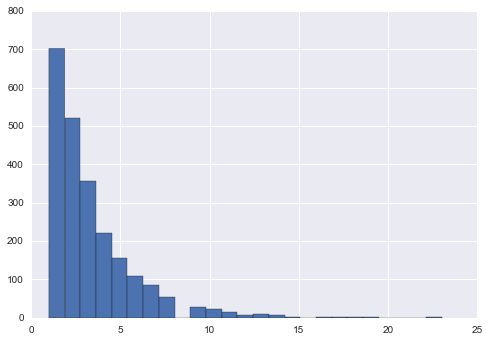

In [10]:
pd_additive.additives_n.hist(bins=25)

Since We would be using Additives_n column for Regression model we shall create a new column called'High Add' .


If Additives_n > 4 ,
     
   High Add = 1.
 
Else 

   High Add = 0.

In [11]:
pd_new['high_add'] = np.where(pd_new['additives_n']>4, '1', '0')

In [12]:
len(pd_new[pd_new['high_add'] == '1'])

505

Around 505 items out of 4454 records have more than 4 additives in ingredients. Around 12% records have high additives

##### Based on the Top 20 ingredients and checking the Top 20 Additives on Web , we create new dummy variables.

TOP 15 Additives 

1. DEXTROSE
2. CITRIC ACID
3. COCOA BUTTER
4. GLUCOSE
5. CORN SYRUP
6.  CARBONATED WATER
7. PALM OIL
8. MONOSODIUM GLUTAMATE
9. HYDROGENATED OIL
10. ARTIFICIAL COLORS
11. SODIUM NITRATE / SODIUM NITRITE
12. BHA
13. BHT
14. CORN STARCH
15. ARTIFICAL SWEETNERS- Saccharin,Aspartame,Sucralose,Agave nectar,Bleached starch



In [13]:
pd_new['ingredients_text'] = pd_new['ingredients_text'].str.upper()

In [14]:
def new_column(column_name,label):
    
    pattern = '|'.join(label)
    
    pd_new[column_name] = pd_new['ingredients_text'].str.contains(pattern)
    pd_new.column_name = pd_new.column_name.astype(int)
    
    return pd_new[column_name]

### 5.3.2 - Create dummy variables for Ingredients and Categories

In [16]:
# Check if Ingredients have Wheat .

#pd_new['has_wheat'] = pd_new['ingredients_text'].str.match('Wheat|wheat',case = '1', na='0')

wheat = ['Wheat','wheat','Weizen','blé','trigo','WHEAT']
pattern = '|'.join(wheat)
pd_new['has_wheat'] = pd_new['ingredients_text'].str.contains(pattern)
pd_new.has_wheat = pd_new.has_wheat.astype(int)


# Check if Ingredients has Salt.

salt = ['Salt','SALT','SAL','SALZ','SEL']
pattern = '|'.join(salt)
pd_new['has_salt'] = pd_new['ingredients_text'].str.contains(pattern) 
pd_new.has_salt = pd_new.has_salt.astype(int)

# Check if Ingredients has Sugar

sugar = ['SUGAR','SUCRE','AZÚCAR','ZUCKER','Sugar']
sugar = '|'.join(sugar)
pd_new['has_sugar'] = pd_new['ingredients_text'].str.contains(sugar)
pd_new.has_sugar = pd_new.has_sugar.astype(int)

# Check if Ingredients has Chocolate .

chocolate = ['CHOCO','CHOCOLATE','CHOCOLAT','SCHOKOLADE','Chocolate']
chocolate = '|'.join(chocolate)
pd_new['has_choco'] = pd_new['ingredients_text'].str.contains(chocolate)
pd_new.has_choco = pd_new.has_choco.astype(int)

# Check if Ingredients has Milk

milk = ['MILK','LECHE','MILCHE','LAIT','Milk']
milk = '|'.join(milk)

pd_new['has_milk'] = pd_new['ingredients_text'].str.contains(milk)
pd_new.has_milk = pd_new.has_milk.astype(int)

# Check if Ingredients has Color

color = ['Color','COLOR','FARBE','COULEUR']
color = '|'.join(color)

pd_new['has_color'] = pd_new['ingredients_text'].str.contains(color)
pd_new.has_color = pd_new.has_color.astype(int)

# Check if Ingredients has MSG

msg = ['MSG','Msg','MONOSODIUM GLUTAMATE']
msg = '|'.join(msg)

pd_new['has_msg'] = pd_new['ingredients_text'].str.contains(msg)
pd_new.has_msg = pd_new.has_msg.astype(int)

# Check if Ingredients has YEAST

yeast = ['Yeast','YEAST','LEVURE','HEFE','LEVADURA']
yeast = '|'.join(yeast)

pd_new['has_yeast'] = pd_new['ingredients_text'].str.contains(yeast)
pd_new.has_yeast = pd_new.has_yeast.astype(int)

# Check if Ingredients has cocoa butter

cocoa = ['Cocoa Butter','COCOA BUTTER','COCOA','KAKAOBUTTER','LE BEURRE DE CACAO','CACAO','KAKAO']
cocoa = '|'.join(cocoa)

pd_new['has_cocoa'] = pd_new['ingredients_text'].str.contains(cocoa)
pd_new.has_cocoa = pd_new.has_cocoa.astype(int)

# Check if Ingredients has Palm Oil

palm = ['Palm Oil','PALM OIL','PALMÖL','HUILE DE PALME','ACEITE DE PALMA']
palm = '|'.join(palm)

pd_new['has_palm'] = pd_new['ingredients_text'].str.contains(palm)
pd_new.has_palm = pd_new.has_palm.astype(int)
    


In [17]:
# Additional Columns
# Check if Ingredients has Water

water = ['WATER','water','WASSER','AGUA','EAU']
water = '|'.join(water)

pd_new['has_water'] = pd_new['ingredients_text'].str.contains(water)
pd_new.has_water = pd_new.has_water.astype(int)

# Check if Ingredients has Garlic

garlic = ['Garlic','GARLIC','AIL','KNOBLAUCH','AJO']
garlic = '|'.join(garlic)

pd_new['has_garlic'] = pd_new['ingredients_text'].str.contains(garlic)
pd_new.has_garlic = pd_new.has_garlic.astype(int)

# Check if Ingredients has Flour

flour = ['Flour','FLOUR','MEHL','FARINE','HARINA']
flour = '|'.join(flour)

pd_new['has_flour'] = pd_new['ingredients_text'].str.contains(flour)
pd_new.has_flour = pd_new.has_flour.astype(int)

# Check if Ingredients has Ginger

ginger = ['Ginger','GINGER','GINGREMBRE','INGWER','JINGIBRE']
ginger = '|'.join(ginger)

pd_new['has_ginger'] = pd_new['ingredients_text'].str.contains(ginger)
pd_new.has_ginger = pd_new.has_ginger.astype(int)

# Check if Ingredients has honey

honey = ['Honey','HONEY','HONIG','MIEL']
honey = '|'.join(honey)

pd_new['has_honey'] = pd_new['ingredients_text'].str.contains(honey)
pd_new.has_honey = pd_new.has_honey.astype(int)

# Check if Ingredients has Spices

spice = ['Spices','SPICES','ÉPICES','GEWÜRZE','Especias']
spice = '|'.join(spice)

pd_new['has_spice'] = pd_new['ingredients_text'].str.contains(spice)
pd_new.has_spice = pd_new.has_spice.astype(int)

# Check if Ingredients has Onion

onion = ['Onion','ONION','OIGNON','ZWIEBEL','CEBOLLA']
onion = '|'.join(onion)

pd_new['has_onion'] = pd_new['ingredients_text'].str.contains(onion)
pd_new.has_onion = pd_new.has_onion.astype(int)



In [18]:
pd_new.head()

,code,product_name,ingredients_text,additives,additives_n,main_category_en,high_add,has_wheat,has_salt,has_sugar,...,has_yeast,has_cocoa,has_palm,has_water,has_garlic,has_flour,has_ginger,has_honey,has_spice,has_onion
5,0000000056434,diet lemonade by Sainsbury's,"CARBONATED WATER, ACID: CITRIC ACID; FLAVOURI...",[ carbonated-water -> en:carbonated-water ] ...,4.0,NaN,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
6,0000001071894,Flute,WHEAT,[ wheat -> en:wheat ],0.0,Plant-based foods and beverages,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0000001471762,still Scottish water,WATER,[ water -> en:water ],0.0,NaN,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
8,0000001798180,Fairtrade Ground Cinnamon,CINNAMON,[ cinnamon -> en:cinnamon ],0.0,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0000005200016,lentilles vertes,LENTILLES VERTES,[ lentilles-vertes -> fr:lentilles-vertes ] ...,0.0,Plant-based foods and beverages,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Create Dummy Variables for each of the Categories. The Top 20 Categories are -

Plant-based foods and beverages                     
Sugary snacks                                        
Beverages                                            
Dairies                                              
Groceries                                            
Meats                                                
Fresh foods                                          
Meals                                                
Salty snacks                                         
Canned foods                                         
Frozen foods                                         
Fruit juices                                         
Breakfasts                                            
Seafood                                               
Desserts                                              
          

### Create Additional Dummy Columns in dataframe for TOP 20 CATEGORIES

In [19]:
# Create columns on Categories 
pd_new['is_plant'] =  np.where(pd_new['main_category_en'] == 'Plant-based foods and beverages', '1', '0')
pd_new.is_plant = pd_new.is_plant.astype(int)

pd_new['is_bev'] = np.where(pd_new['main_category_en'] == 'Beverages','1','0')
pd_new.is_bev = pd_new.is_bev.astype(int)

pd_new['is_sugar'] = np.where(pd_new['main_category_en'] == 'Sugary snacks','1','0')
pd_new.is_sugar = pd_new.is_sugar.astype(int)

pd_new['is_salt'] = np.where(pd_new['main_category_en'] == 'Salty snacks','1','0')
pd_new.is_salt = pd_new.is_salt.astype(int)

pd_new['is_dairy'] = np.where(pd_new['main_category_en'] == 'Dairies','1','0')
pd_new.is_dairy = pd_new.is_dairy.astype(int)

pd_new['is_meat'] = np.where(pd_new['main_category_en'] == 'Meats|Seafood','1','0')
pd_new.is_meat = pd_new.is_meat.astype(int)

pd_new['is_fresh'] = np.where(pd_new['main_category_en'] == 'Fresh foods','1','0')
pd_new.is_fresh = pd_new.is_fresh.astype(int)

pd_new['is_break'] = np.where(pd_new['main_category_en'] == 'Breakfasts','1','0')
pd_new.is_break = pd_new.is_break.astype(int)

pd_new['is_frozen'] = np.where(pd_new['main_category_en'] == 'Frozen foods','1','0')
pd_new.is_frozen = pd_new.is_frozen.astype(int)

pd_new['is_juices'] = np.where(pd_new['main_category_en'] == 'Fruit Juices','1','0')
pd_new.is_juices = pd_new.is_juices.astype(int)



In [20]:
# manually add the intercept
pd_new['intercept'] = 1.0

In [21]:
pd_new['high_add'] = pd_new['high_add'].astype(int)

In [22]:
pd_new['text_count'] = pd_new['ingredients_text'].apply(lambda x: x.count(',') + 1)

In [23]:
#pd_new.to_csv('abcd.csv')
pd_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4454 entries, 5 to 9999
Data columns (total 36 columns):
code                4454 non-null object
product_name        4417 non-null object
ingredients_text    4454 non-null object
additives           3987 non-null object
additives_n         4452 non-null float64
main_category_en    4192 non-null object
high_add            4454 non-null int64
has_wheat           4454 non-null int64
has_salt            4454 non-null int64
has_sugar           4454 non-null int64
has_choco           4454 non-null int64
has_milk            4454 non-null int64
has_color           4454 non-null int64
has_msg             4454 non-null int64
has_yeast           4454 non-null int64
has_cocoa           4454 non-null int64
has_palm            4454 non-null int64
has_water           4454 non-null int64
has_garlic          4454 non-null int64
has_flour           4454 non-null int64
has_ginger          4454 non-null int64
has_honey           4454 non-null int64
has_sp

In [24]:
pd_new.head()

,code,product_name,ingredients_text,additives,additives_n,main_category_en,high_add,has_wheat,has_salt,has_sugar,...,is_sugar,is_salt,is_dairy,is_meat,is_fresh,is_break,is_frozen,is_juices,intercept,text_count
5,0000000056434,diet lemonade by Sainsbury's,"CARBONATED WATER, ACID: CITRIC ACID; FLAVOURI...",[ carbonated-water -> en:carbonated-water ] ...,4.0,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,3
6,0000001071894,Flute,WHEAT,[ wheat -> en:wheat ],0.0,Plant-based foods and beverages,0,1,0,0,...,0,0,0,0,0,0,0,0,1.0,1
7,0000001471762,still Scottish water,WATER,[ water -> en:water ],0.0,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,1
8,0000001798180,Fairtrade Ground Cinnamon,CINNAMON,[ cinnamon -> en:cinnamon ],0.0,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,1
9,0000005200016,lentilles vertes,LENTILLES VERTES,[ lentilles-vertes -> fr:lentilles-vertes ] ...,0.0,Plant-based foods and beverages,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,1


In [25]:
pd_new[['ingredients_text','text_count']].head(10)

,ingredients_text,text_count
5,"CARBONATED WATER, ACID: CITRIC ACID; FLAVOURI...",3
6,WHEAT,1
7,WATER,1
8,CINNAMON,1
9,LENTILLES VERTES,1
11,"SUCRE, FARINE DE _BLÉ_, GRAISSE ET HUILES VÉGÉ...",15
12,"THÉ NOIR DE CHINE, ZESTES D'ORANGES 7,5 %, ARÔ...",9
13,"SIROP SAVEUR PISTACHE 5 CL : SIROP 99,16 % (SU...",39
14,ตีนไก่,1
16,77,1


### 5.4 LOGISTIC REGRESSION MODEL

### 5.4.1  - Baseline Model

In [26]:
# Creating the model with 7 dependant columns

train_cols = [ 'has_wheat' , 'has_salt' , 'has_sugar', 'has_choco' ,'has_milk','has_cocoa','has_palm','intercept']
#               'has_water', 'has_garlic','has_flour' ,'has_ginger','has_honey',

logit = sm.Logit(pd_new['high_add'], pd_new[train_cols])

# fit the model
result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.306835
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               high_add   No. Observations:                 4454
Model:                          Logit   Df Residuals:                     4446
Method:                           MLE   Df Model:                            7
Date:                Tue, 06 Dec 2016   Pseudo R-squ.:                  0.1321
Time:                        23:30:19   Log-Likelihood:                -1366.6
converged:                       True   LL-Null:                       -1574.6
                                        LLR p-value:                 9.131e-86
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
has_wheat      0.7141      0.143      5.005      0.000         0.434     0.994
has_salt       0.8491      0.118      7.204      0.000         0.618     1.080
has_sugar      0.7972      0.112      7.092      0.000         0.577     1.018
has_choco      0.4492      0.251      1.792      0.073        -0.042     0.941
has_milk       0.8521      0.107      7.935      0.000         0.642     1.063
has_cocoa     -0.5877      0.222     -2.652      0.008        -1.022    -0.153
has_palm       0.8585      0.167      5.131      0.000         0.531     1.186
intercept     -3.4025      0.111    -30.642      0.000        -3.620    -3.185
==============================================================================
"""

In [33]:
# Find the actual values of ones and zeros in each dummy column
#print(pd_new.has_wheat.sum())
#print(pd_new.has_salt.sum())
#print(pd_new.has_palm.sum())
#print(pd_new.has_sugar.sum())
#print(pd_new.has_cocoa.sum())
#print(pd_new.has_milk.sum())
#print(pd_new.has_color.sum())

In [27]:
# look at the confidence interval of each coeffecient
result.conf_int()

,0,1
has_wheat,0.434454,0.993810
has_salt,0.618117,1.080173
has_sugar,0.576910,1.017536
has_choco,-0.042165,0.940580
has_milk,0.641628,1.062586
has_cocoa,-1.021989,-0.153354
has_palm,0.530542,1.186377
intercept,-3.620184,-3.184909


###### Odds Ratio

In [28]:
np.exp(result.params)

has_wheat    2.042413
has_salt     2.337647
has_sugar    2.219369
has_choco    1.567070
has_milk     2.344581
has_cocoa    0.555620
has_palm     2.359524
intercept    0.033288
dtype: float64

In [29]:
params = result.params

conf = result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
print (np.exp(conf))

               2.5%     97.5%        OR
has_wheat  1.544120  2.701508  2.042413
has_salt   1.855430  2.945190  2.337647
has_sugar  1.780528  2.766370  2.219369
has_choco  0.958712  2.561468  1.567070
has_milk   1.899571  2.893844  2.344581
has_cocoa  0.359879  0.857826  0.555620
has_palm   1.699854  3.275195  2.359524
intercept  0.026778  0.041382  0.033288


In [30]:
# Predict Y column using the logit function.
pd_new['ypred'] = result.predict(pd_new[train_cols])


In [31]:
pd_new[['high_add','ypred']].head()

,high_add,ypred
5,0,0.032216
6,0,0.063660
7,0,0.032216
8,0,0.032216
9,0,0.032216


Converting the ypred probability into value of 0 and 1

In [32]:
pd_new['ypred_class'] = np.where(pd_new['ypred']>0.12, '1', '0')
pd_new['ypred_class'] = pd_new['ypred_class'].astype(int)


In [33]:
# Create confusin matrix from Scikit
matrix = confusion_matrix(pd_new['high_add'], pd_new['ypred_class'])
print(matrix)


[[2699 1250]
 [ 144  361]]


In [34]:
# Using Pandas confusion create the confusion matrix

from pandas_confusion import ConfusionMatrix

confusion_matrix = ConfusionMatrix(pd_new['high_add'], pd_new['ypred_class'])
print("Confusion matrix:\n%s" % confusion_matrix)

Confusion matrix:
Predicted     0     1  __all__
Actual                        
0          2699  1250     3949
1           144   361      505
__all__    2843  1611     4454


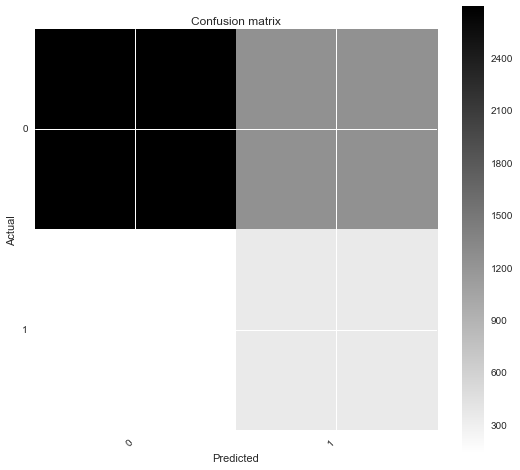

In [35]:
confusion_matrix.plot()
plt.show()

Statistics of the Model

In [36]:
confusion_matrix.print_stats()

Confusion Matrix:

Predicted     0     1  __all__
Actual                        
0          2699  1250     3949
1           144   361      505
__all__    2843  1611     4454


Overall Statistics:

Accuracy: 0.687022900763
95% CI: (0.67317322857085415, 0.70062694192579322)
No Information Rate: ToDo
P-Value [Acc > NIR]: 4.45220001629e-12
Kappa: 0.203740557616
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                        0          1
Population                                  4454       4454
P: Condition positive                       3949        505
N: Condition negative                        505       3949
Test outcome positive                       2843       1611
Test outcome negative                       1611       2843
TP: True Positive                           2699        361
TN: True Negative                            361       2699
FP: False Positive                           144       1250
FN: False Negative                          1250  

In [45]:
# Another way of calculating accuracy score
#X.mean()
#Ypred = (result.predict(pd_new[train_cols]) >= 0.12)
#true_pos = Ypred * X
#true_neg = (1 - Ypred) * (1 - X)
#acc = (sum(true_pos) + sum(true_neg))/len(X)
#acc

In [37]:
# Create ROC curve for Baseline model
false_positive_rate, true_positive_rate, thresholds = roc_curve(pd_new['high_add'], pd_new['ypred'])
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc


0.75054268658063572

Overall Accuracy of the Model above is around 68% which is a good, so these predictor variables do have some
influence on high additives.

Model was able to predict around 2699 true positives out of 4454 records which is a good sign

### 5.4.2 Random Model created using Random Values for predictor variables

In [38]:
#New model - Create a new dataframe with random values in 7 columns and cross check with above logit model

pd_random = pd_new[['code','product_name','high_add']]
pd_size = len(pd_random)

pd_random['col1'] = np.random.randint(2, size=pd_size)
pd_random['col2'] = np.random.randint(2, size=pd_size)
pd_random['col3'] = np.random.randint(2, size=pd_size)
pd_random['col4'] = np.random.randint(2, size=pd_size)
pd_random['col5'] = np.random.randint(2, size=pd_size)
pd_random['col6'] = np.random.randint(2, size=pd_size)
pd_random['col7'] = np.random.randint(2, size=pd_size)


/Users/vingadgil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/vingadgil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/vingadgil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

In [39]:
pd_random['intercept'] = 1.0
pd_random.head()

/Users/vingadgil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,code,product_name,high_add,col1,col2,col3,col4,col5,col6,col7,intercept
5,0000000056434,diet lemonade by Sainsbury's,0,1,1,0,1,0,0,0,1.0
6,0000001071894,Flute,0,0,1,1,0,1,0,1,1.0
7,0000001471762,still Scottish water,0,1,0,0,0,1,0,1,1.0
8,0000001798180,Fairtrade Ground Cinnamon,0,0,1,1,0,1,0,0,1.0
9,0000005200016,lentilles vertes,0,0,1,1,0,1,1,0,1.0


In [40]:
train_cols_r = [ 'col1' , 'col2' , 'col3', 'col4' ,'col5','col6','col7','intercept']
logit_random = sm.Logit(pd_random['high_add'], pd_random[train_cols_r])

# fit the model
result_random = logit_random.fit()
result_random.summary()

Optimization terminated successfully.
         Current function value: 0.352574
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               high_add   No. Observations:                 4454
Model:                          Logit   Df Residuals:                     4446
Method:                           MLE   Df Model:                            7
Date:                Tue, 06 Dec 2016   Pseudo R-squ.:                0.002694
Time:                        23:40:18   Log-Likelihood:                -1570.4
converged:                       True   LL-Null:                       -1574.6
                                        LLR p-value:                    0.2920
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
col1           0.0534      0.095      0.564      0.572        -0.132     0.239
col2           0.1811      0.095      1.909      0.056        -0.005     0.367
col3           0.0772      0.095      0.815      0.415        -0.108     0.263
col4          -0.1476      0.095     -1.558      0.119        -0.333     0.038
col5           0.0308      0.095      0.325      0.745        -0.155     0.216
col6          -0.0281      0.095     -0.297      0.766        -0.214     0.157
col7          -0.0960      0.095     -1.013      0.311        -0.282     0.090
intercept     -2.0967      0.133    -15.749      0.000        -2.358    -1.836
==============================================================================
"""

In [41]:
# Predict Y using the logit function.
pd_random['ypred'] = result.predict(pd_random[train_cols_r])

/Users/vingadgil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [43]:
pd_random['ypred_class'] = np.where(pd_random['ypred']>0.12, '1', '0')
pd_random['ypred_class'] = pd_random['ypred_class'].astype(int)

/Users/vingadgil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/vingadgil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [44]:
from pandas_confusion import ConfusionMatrix

matrix_random = ConfusionMatrix(pd_random['high_add'], pd_random['ypred_class'])
print("Confusion matrix:\n%s" % matrix_random)


Confusion matrix:
Predicted     0     1  __all__
Actual                        
0          1076  2873     3949
1           129   376      505
__all__    1205  3249     4454


In [46]:
#matrix_random.plot()
#plt.show()

In [45]:
# Calculate the accuracy score
matrix_random.print_stats()

Confusion Matrix:

Predicted     0     1  __all__
Actual                        
0          1076  2873     3949
1           129   376      505
__all__    1205  3249     4454


Overall Statistics:

Accuracy: 0.325999101931
95% CI: (0.31223851519123996, 0.33998819058965579)
No Information Rate: ToDo
P-Value [Acc > NIR]: 1.0
Kappa: 0.00505386408009
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                         0           1
Population                                   4454        4454
P: Condition positive                        3949         505
N: Condition negative                         505        3949
Test outcome positive                        1205        3249
Test outcome negative                        3249        1205
TP: True Positive                            1076         376
TN: True Negative                             376        1076
FP: False Positive                            129        2873
FN: False Negative                          

In [46]:
# ROC values for Random Model
false_positive_ran, true_positive_ran, thresholds_ran = roc_curve(pd_random['high_add'], pd_random['ypred'])
roc_auc_ran = auc(false_positive_ran, true_positive_ran)
roc_auc_ran

0.51191779345065425

In [47]:
print(metrics.classification_report(pd_new['high_add'], pd_new['ypred_class']))

             precision    recall  f1-score   support

          0       0.95      0.68      0.79      3949
          1       0.22      0.71      0.34       505

avg / total       0.87      0.69      0.74      4454



Accuracy of the Random model is around 32% which is half that of that Baseline model. So Baseline Model looks better than random model, it has predicted more False Negatives. Model has predicted more Wrong values.


### 5.4.3 Model with 12 Dependant Variable

In [48]:
# 12 Ingredients variables

train_cols_12 = [ 'has_wheat' , 'has_salt' , 'has_sugar', 'has_choco' ,'has_milk','has_cocoa','has_palm',
               'has_water', 'has_garlic','has_flour' ,'has_ginger','has_honey','intercept']

logit_12 = sm.Logit(pd_new['high_add'], pd_new[train_cols_12])

# fit the model
result_12 = logit_12.fit()
result_12.summary()

Optimization terminated successfully.
         Current function value: 0.291784
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               high_add   No. Observations:                 4454
Model:                          Logit   Df Residuals:                     4441
Method:                           MLE   Df Model:                           12
Date:                Tue, 06 Dec 2016   Pseudo R-squ.:                  0.1746
Time:                        23:44:01   Log-Likelihood:                -1299.6
converged:                       True   LL-Null:                       -1574.6
                                        LLR p-value:                4.930e-110
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
has_wheat      0.5492      0.163      3.370      0.001         0.230     0.869
has_salt       0.4594      0.131      3.505      0.000         0.203     0.716
has_sugar      0.5677      0.118      4.818      0.000         0.337     0.799
has_choco      0.2472      0.262      0.945      0.345        -0.266     0.760
has_milk       0.8951      0.112      7.985      0.000         0.675     1.115
has_cocoa     -0.2960      0.234     -1.263      0.207        -0.756     0.163
has_palm       0.9538      0.178      5.365      0.000         0.605     1.302
has_water      1.0891      0.111      9.793      0.000         0.871     1.307
has_garlic    -0.2728      0.163     -1.671      0.095        -0.593     0.047
has_flour      0.6211      0.133      4.684      0.000         0.361     0.881
has_ginger    -0.0389      0.317     -0.123      0.902        -0.660     0.582
has_honey     -0.5302      0.310     -1.711      0.087        -1.138     0.077
intercept     -3.6988      0.122    -30.410      0.000        -3.937    -3.460
==============================================================================
"""

In [49]:
result_12.conf_int()

,0,1
has_wheat,0.229763,0.868601
has_salt,0.202514,0.716287
has_sugar,0.336761,0.798678
has_choco,-0.265737,0.760091
has_milk,0.675382,1.114768
has_cocoa,-0.755525,0.163443
has_palm,0.605317,1.302232
has_water,0.871106,1.307058
has_garlic,-0.592678,0.047123
has_flour,0.361219,0.880945


In [50]:
np.exp(result_12.params)

has_wheat     1.731836
has_salt      1.583124
has_sugar     1.764239
has_choco     1.280406
has_milk      2.447519
has_cocoa     0.743757
has_palm      2.595489
has_water     2.971545
has_garlic    0.761262
has_flour     1.860940
has_ginger    0.961875
has_honey     0.588464
intercept     0.024753
dtype: float64

In [51]:
# Predict Y using the logit function.
pd_new['ypred_12'] = result_12.predict(pd_new[train_cols_12])

pd_new['ypred_class_12'] = np.where(pd_new['ypred_12']>0.12, '1', '0')
pd_new['ypred_class_12'] = pd_new['ypred_class_12'].astype(int)


In [52]:
confusion_matrix_12 = ConfusionMatrix(pd_new['high_add'], pd_new['ypred_class_12'])
#print("Confusion matrix:\n%s" % confusion_matrix_12)

confusion_matrix_12.print_stats()

Confusion Matrix:

Predicted     0     1  __all__
Actual                        
0          3121   828     3949
1           168   337      505
__all__    3289  1165     4454


Overall Statistics:

Accuracy: 0.77638078132
95% CI: (0.76385270352273649, 0.78854542877754974)
No Information Rate: ToDo
P-Value [Acc > NIR]: 2.62514302925e-09
Kappa: 0.29151756839
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                        0          1
Population                                  4454       4454
P: Condition positive                       3949        505
N: Condition negative                        505       3949
Test outcome positive                       3289       1165
Test outcome negative                       1165       3289
TP: True Positive                           3121        337
TN: True Negative                            337       3121
FP: False Positive                           168        828
FN: False Negative                           828    

In [53]:
# Create ROC curve for 12 model
false_positive_rate_12, true_positive_rate_12, thresholds = roc_curve(pd_new['high_add'], pd_new['ypred_12'])
roc_auc_12 = auc(false_positive_rate_12, true_positive_rate_12)
roc_auc_12

0.79125333146127974

Accuracy of this Model is now 77% which is better than Baseline model. We are able to predict more True Positives 
in this model

### 5.4.4 Model with Ingredients and Categories

Create Logitistic Regression with Ingredients and Category Dependant Variable

In [54]:
train_cols_20 = [ 'has_wheat' , 'has_salt' , 'has_sugar', 'has_choco' ,'has_milk','has_cocoa','has_palm',
               'has_water', 'has_garlic','has_flour' ,'has_ginger','has_honey','is_plant','is_bev',
                 'is_sugar','is_salt','is_frozen','is_break','is_dairy','is_fresh','intercept']

#'is_frozen' ,'is_break' ,'is_dairy', 'is_fresh' ,'is_meat'

logit_20 = sm.Logit(pd_new['high_add'], pd_new[train_cols_20])

# fit the model
result_20 = logit_20.fit()
result_20.summary()

Optimization terminated successfully.
         Current function value: 0.287132
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Actual   No. Observations:                 4454
Model:                          Logit   Df Residuals:                     4433
Method:                           MLE   Df Model:                           20
Date:                Tue, 06 Dec 2016   Pseudo R-squ.:                  0.1878
Time:                        23:48:26   Log-Likelihood:                -1278.9
converged:                       True   LL-Null:                       -1574.6
                                        LLR p-value:                1.825e-112
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
has_wheat      0.5827      0.168      3.464      0.001         0.253     0.912
has_salt       0.3723      0.141      2.634      0.008         0.095     0.649
has_sugar      0.4756      0.121      3.922      0.000         0.238     0.713
has_choco      0.1431      0.261      0.548      0.584        -0.369     0.655
has_milk       0.8027      0.120      6.687      0.000         0.567     1.038
has_cocoa     -0.5811      0.245     -2.375      0.018        -1.061    -0.102
has_palm       0.9487      0.181      5.243      0.000         0.594     1.303
has_water      1.1756      0.121      9.715      0.000         0.938     1.413
has_garlic    -0.1770      0.166     -1.069      0.285        -0.502     0.148
has_flour      0.6421      0.141      4.556      0.000         0.366     0.918
has_ginger    -0.2097      0.328     -0.640      0.522        -0.852     0.433
has_honey     -0.4887      0.314     -1.554      0.120        -1.105     0.128
is_plant      -0.7324      0.174     -4.203      0.000        -1.074    -0.391
is_bev        -0.2957      0.233     -1.272      0.204        -0.751     0.160
is_sugar       0.5346      0.180      2.975      0.003         0.182     0.887
is_salt       -0.0245      0.333     -0.074      0.941        -0.677     0.628
is_frozen     -0.8833      0.442     -1.999      0.046        -1.749    -0.017
is_break       0.3012      0.428      0.704      0.481        -0.537     1.139
is_dairy      -0.1105      0.238     -0.463      0.643        -0.578     0.357
is_fresh       0.0597      0.276      0.216      0.829        -0.481     0.600
intercept     -3.5088      0.144    -24.354      0.000        -3.791    -3.226
==============================================================================
"""

In [55]:
result_20.conf_int()

,0,1
has_wheat,0.253020,0.912417
has_salt,0.095318,0.649277
has_sugar,0.237938,0.713354
has_choco,-0.368682,0.654917
has_milk,0.567461,1.038025
has_cocoa,-1.060728,-0.101528
has_palm,0.594078,1.303353
has_water,0.938459,1.412801
has_garlic,-0.501608,0.147577
has_flour,0.365864,0.918319


In [56]:
np.exp(result_20.params)


has_wheat     1.790901
has_salt      1.451064
has_sugar     1.609053
has_choco     1.153865
has_milk      2.231654
has_cocoa     0.559267
has_palm      2.582391
has_water     3.240182
has_garlic    0.837767
has_flour     1.900451
has_ginger    0.810818
has_honey     0.613428
is_plant      0.480748
is_bev        0.744024
is_sugar      1.706830
is_salt       0.975789
is_frozen     0.413415
is_break      1.351443
is_dairy      0.895376
is_fresh      1.061469
intercept     0.029933
dtype: float64

In [57]:
# Predict Y using the logit function.
pd_new['ypred_20'] = result_20.predict(pd_new[train_cols_20])

pd_new['ypred_class_20'] = np.where(pd_new['ypred_20']>0.12, '1', '0')
pd_new['ypred_class_20'] = pd_new['ypred_class_20'].astype(int)

In [58]:
confusion_matrix_20 = ConfusionMatrix(pd_new['high_add'], pd_new['ypred_class_20'])
#print("Confusion matrix:\n%s" % confusion_matrix_20)

confusion_matrix_20.print_stats()

Confusion Matrix:

Predicted     0     1  __all__
Actual                        
0          2992   957     3949
1           141   364      505
__all__    3133  1321     4454


Overall Statistics:

Accuracy: 0.753480017961
95% CI: (0.74054692050475879, 0.76607993050642931)
No Information Rate: ToDo
P-Value [Acc > NIR]: 5.49273631902e-14
Kappa: 0.280682426913
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                        0          1
Population                                  4454       4454
P: Condition positive                       3949        505
N: Condition negative                        505       3949
Test outcome positive                       3133       1321
Test outcome negative                       1321       3133
TP: True Positive                           2992        364
TN: True Negative                            364       2992
FP: False Positive                           141        957
FN: False Negative                           957  

In [59]:
# Create ROC curve for  model with 20 dependant variables
false_positive_rate_20, true_positive_rate_20, thresholds = roc_curve(pd_new['high_add'], pd_new['ypred_20'])
roc_auc_20 = auc(false_positive_rate_20, true_positive_rate_20)
roc_auc_20

0.8082016001043002

Acurracy is around 75 % which is a good fit Model .

### 5.4.5 Model with Ingredients text , Categories and Ingredients Count

In [60]:
train_cols_21 = [ 'has_wheat' , 'has_salt' , 'has_sugar', 'has_choco' ,'has_milk','has_cocoa','has_palm',
               'has_water', 'has_garlic','has_flour' ,'has_ginger','has_honey','is_plant','is_bev',
                 'is_sugar','is_salt','is_frozen','is_break','is_dairy','is_fresh','text_count','intercept']

#'is_frozen' ,'is_break' ,'is_dairy', 'is_fresh' ,'is_meat'

logit_21 = sm.Logit(pd_new['high_add'], pd_new[train_cols_21])

# fit the model
result_21 = logit_21.fit()
result_21.summary()

Optimization terminated successfully.
         Current function value: 0.225210
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Actual   No. Observations:                 4454
Model:                          Logit   Df Residuals:                     4432
Method:                           MLE   Df Model:                           21
Date:                Tue, 06 Dec 2016   Pseudo R-squ.:                  0.3630
Time:                        23:51:50   Log-Likelihood:                -1003.1
converged:                       True   LL-Null:                       -1574.6
                                        LLR p-value:                8.604e-229
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
has_wheat     -0.1230      0.208     -0.591      0.555        -0.531     0.285
has_salt      -0.3441      0.165     -2.088      0.037        -0.667    -0.021
has_sugar     -0.1655      0.141     -1.170      0.242        -0.443     0.112
has_choco     -0.3075      0.310     -0.993      0.321        -0.914     0.299
has_milk      -0.0359      0.144     -0.250      0.803        -0.318     0.246
has_cocoa     -0.8572      0.280     -3.058      0.002        -1.407    -0.308
has_palm       0.7269      0.220      3.303      0.001         0.296     1.158
has_water      0.4987      0.142      3.522      0.000         0.221     0.776
has_garlic    -1.4341      0.221     -6.476      0.000        -1.868    -1.000
has_flour     -0.2043      0.171     -1.195      0.232        -0.539     0.131
has_ginger    -3.0551      0.480     -6.367      0.000        -3.996    -2.115
has_honey     -1.0698      0.368     -2.910      0.004        -1.790    -0.349
is_plant      -0.8157      0.207     -3.935      0.000        -1.222    -0.409
is_bev         0.0494      0.248      0.199      0.842        -0.437     0.536
is_sugar       0.9017      0.200      4.507      0.000         0.510     1.294
is_salt        0.2540      0.373      0.681      0.496        -0.477     0.985
is_frozen     -2.8317      0.653     -4.336      0.000        -4.112    -1.552
is_break       0.7859      0.503      1.564      0.118        -0.199     1.771
is_dairy       0.3131      0.259      1.210      0.226        -0.194     0.820
is_fresh      -1.1797      0.352     -3.351      0.001        -1.870    -0.490
text_count     0.1864      0.010     19.178      0.000         0.167     0.205
intercept     -4.1045      0.165    -24.814      0.000        -4.429    -3.780
==============================================================================
"""

In [61]:
result_21.conf_int()

,0,1
has_wheat,-0.530994,0.284951
has_salt,-0.667114,-0.021134
has_sugar,-0.442575,0.111647
has_choco,-0.914400,0.299356
has_milk,-0.317538,0.245795
has_cocoa,-1.406537,-0.307888
has_palm,0.295641,1.158246
has_water,0.221209,0.776165
has_garlic,-1.868192,-1.000085
has_flour,-0.539249,0.130704


In [62]:
np.exp(result_21.params)

has_wheat     0.884245
has_salt      0.708841
has_sugar     0.847500
has_choco     0.735267
has_milk      0.964764
has_cocoa     0.424343
has_palm      2.068749
has_water     1.646558
has_garlic    0.238320
has_flour     0.815240
has_ginger    0.047116
has_honey     0.343084
is_plant      0.442331
is_bev        1.050684
is_sugar      2.463678
is_salt       1.289191
is_frozen     0.058912
is_break      2.194466
is_dairy      1.367705
is_fresh      0.307366
text_count    1.204882
intercept     0.016498
dtype: float64

In [63]:
# Predict Y using the logit function.
pd_new['ypred_21'] = result_21.predict(pd_new[train_cols_21])

pd_new['ypred_class_21'] = np.where(pd_new['ypred_21']>0.12, '1', '0')
pd_new['ypred_class_21'] = pd_new['ypred_class_21'].astype(int)

In [64]:
confusion_matrix = ConfusionMatrix(pd_new['high_add'], pd_new['ypred_class_21'])
#print("Confusion matrix:\n%s" % confusion_matrix)

confusion_matrix.print_stats()



Confusion Matrix:

Predicted     0    1  __all__
Actual                       
0          3386  563     3949
1            88  417      505
__all__    3474  980     4454


Overall Statistics:

Accuracy: 0.853839245622
95% CI: (0.84312050288304907, 0.86409171022628684)
No Information Rate: ToDo
P-Value [Acc > NIR]: 6.82490526912e-36
Kappa: 0.484467826733
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                       0         1
Population                                 4454      4454
P: Condition positive                      3949       505
N: Condition negative                       505      3949
Test outcome positive                      3474       980
Test outcome negative                       980      3474
TP: True Positive                          3386       417
TN: True Negative                           417      3386
FP: False Positive                           88       563
FN: False Negative                          563        88
TPR: (Sensitivi

In [65]:

# Create ROC curve for Baseline model
false_positive_21, true_positive_21, thresholds = roc_curve(pd_new['high_add'], pd_new['ypred_21'])
roc_auc_21 = auc(false_positive_21, true_positive_21)
roc_auc_21

0.91624750218754469

Accuracy of this model has increased to 85% so the model is better fit with considering all Ingredients_text,
Ingredient counts and Categories

### 5.4.6 Plot all ROC curve together.

1. Model with 7 dependant variable
2. Random Model with 7 dependant variable
3. Model with 12 dependant variable
3. Model with 20 dependant variable
4. Model with 21 dependant variables

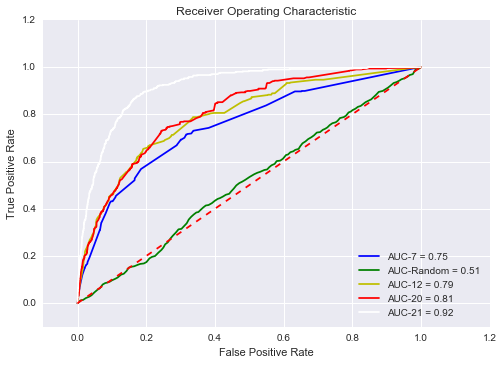

In [67]:
# Plot the actual ROC curve -
# Plot the curve
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC-7 = %0.2f'% roc_auc)
plt.plot(false_positive_ran, true_positive_ran, 'g',
label='AUC-Random = %0.2f'% roc_auc_ran)
plt.plot(false_positive_rate_12, true_positive_rate_12, 'y',
label='AUC-12 = %0.2f'% roc_auc_12)
plt.plot(false_positive_rate_20, true_positive_rate_20, 'r',
label='AUC-20 = %0.2f'% roc_auc_20)
plt.plot(false_positive_21, true_positive_21, 'w',
label='AUC-21 = %0.2f'% roc_auc_21)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

We have generated model with 10,000 records. Now generate the new model with All entries in file. We then divide the file into training data and test data.

### 5.4.7 Real-time full data

In [84]:
# Read the entire csv file into dataframe
main_data = pd.read_csv('en_openfoodfacts_Nov.csv', sep='\t' )

/Users/vingadgil/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0,3,5,27,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [85]:
main_data.shape

(107343, 159)

In [ ]:
#train, test = train_test_split(pd_new, test_size = 0.3)
#len(train)
#len(test)

In [86]:
main_new = main_data[['code' , 'product_name' , 'ingredients_text', 'additives','additives_n','main_category_en']]
main_new = main_new[main_new.ingredients_text.notnull()]

In [87]:
len(main_new)

62266

Out of 107343 records we shall consider only 62266 records. Percantage of data used would be around 68%.

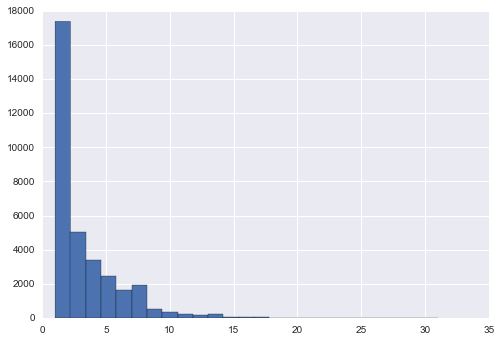

In [88]:
main_additive = main_new[main_new.additives_n > 0]

main_additive.additives_n.hist(bins=25)

In [89]:
main_new['high_add'] = np.where(main_new['additives_n']>4, '1', '0')

len(main_new[main_new['high_add'] == '1'])


7535

In [90]:
main_new.loc['ingredients_text'] = main_new['ingredients_text'].str.upper()

In [91]:
main_new = main_new[main_new.ingredients_text.notnull()]

Creating dummy variables for Ingredients and Categories and text count

In [92]:
# Check if Ingredients have Wheat .

#pd_new['has_wheat'] = pd_new['ingredients_text'].str.match('Wheat|wheat',case = '1', na='0')

wheat = ['Wheat','wheat','Weizen','blé','trigo','WHEAT']
pattern = '|'.join(wheat)
main_new['has_wheat'] = main_new['ingredients_text'].str.contains(pattern)
main_new.has_wheat = main_new.has_wheat.astype(int)


# Check if Ingredients has Salt.

salt = ['Salt','SALT','SAL','SALZ','SEL']
pattern = '|'.join(salt)
main_new['has_salt'] = main_new['ingredients_text'].str.contains(pattern) 
main_new.has_salt = main_new.has_salt.astype(int)

# Check if Ingredients has Sugar

sugar = ['SUGAR','SUCRE','AZÚCAR','ZUCKER','Sugar']
sugar = '|'.join(sugar)
main_new['has_sugar'] = main_new['ingredients_text'].str.contains(sugar)
main_new.has_sugar = main_new.has_sugar.astype(int)

# Check if Ingredients has Chocolate .

chocolate = ['CHOCO','CHOCOLATE','CHOCOLAT','SCHOKOLADE','Chocolate']
chocolate = '|'.join(chocolate)
main_new['has_choco'] = main_new['ingredients_text'].str.contains(chocolate)
main_new.has_choco = main_new.has_choco.astype(int)

# Check if Ingredients has Milk

milk = ['MILK','LECHE','MILCHE','LAIT','Milk']
milk = '|'.join(milk)

main_new['has_milk'] = main_new['ingredients_text'].str.contains(milk)
main_new.has_milk = main_new.has_milk.astype(int)

# Check if Ingredients has Color

color = ['Color','COLOR','FARBE','COULEUR']
color = '|'.join(color)

main_new['has_color'] = main_new['ingredients_text'].str.contains(color)
main_new.has_color = main_new.has_color.astype(int)

# Check if Ingredients has MSG

msg = ['MSG','Msg','MONOSODIUM GLUTAMATE']
msg = '|'.join(msg)

main_new['has_msg'] = main_new['ingredients_text'].str.contains(msg)
main_new.has_msg = main_new.has_msg.astype(int)

# Check if Ingredients has YEAST

yeast = ['Yeast','YEAST','LEVURE','HEFE','LEVADURA']
yeast = '|'.join(yeast)

main_new['has_yeast'] = main_new['ingredients_text'].str.contains(yeast)
main_new.has_yeast = main_new.has_yeast.astype(int)

# Check if Ingredients has cocoa butter

cocoa = ['Cocoa Butter','COCOA BUTTER','COCOA','KAKAOBUTTER','LE BEURRE DE CACAO','CACAO','KAKAO']
cocoa = '|'.join(cocoa)

main_new['has_cocoa'] = main_new['ingredients_text'].str.contains(cocoa)
main_new.has_cocoa = main_new.has_cocoa.astype(int)

# Check if Ingredients has Palm Oil

palm = ['Palm Oil','PALM OIL','PALMÖL','HUILE DE PALME','ACEITE DE PALMA']
palm = '|'.join(palm)

main_new['has_palm'] = main_new['ingredients_text'].str.contains(palm)
main_new.has_palm = main_new.has_palm.astype(int)


In [93]:
# Check if Ingredients has Water

water = ['WATER','water','WASSER','AGUA','EAU']
water = '|'.join(water)

main_new['has_water'] = main_new['ingredients_text'].str.contains(water)
main_new.has_water = main_new.has_water.astype(int)

# Check if Ingredients has Garlic

garlic = ['Garlic','GARLIC','AIL','KNOBLAUCH','AJO']
garlic = '|'.join(garlic)

main_new['has_garlic'] = main_new['ingredients_text'].str.contains(garlic)
main_new.has_garlic = main_new.has_garlic.astype(int)

# Check if Ingredients has Flour

flour = ['Flour','FLOUR','MEHL','FARINE','HARINA']
flour = '|'.join(flour)

main_new['has_flour'] = main_new['ingredients_text'].str.contains(flour)
main_new.has_flour = main_new.has_flour.astype(int)

# Check if Ingredients has Ginger

ginger = ['Ginger','GINGER','GINGREMBRE','INGWER','JINGIBRE']
ginger = '|'.join(ginger)

main_new['has_ginger'] = main_new['ingredients_text'].str.contains(ginger)
main_new.has_ginger = main_new.has_ginger.astype(int)

# Check if Ingredients has honey

honey = ['Honey','HONEY','HONIG','MIEL']
honey = '|'.join(honey)

main_new['has_honey'] = main_new['ingredients_text'].str.contains(honey)
main_new.has_honey = main_new.has_honey.astype(int)

# Check if Ingredients has Spices

spice = ['Spices','SPICES','ÉPICES','GEWÜRZE','Especias']
spice = '|'.join(spice)

main_new['has_spice'] = main_new['ingredients_text'].str.contains(spice)
main_new.has_spice = main_new.has_spice.astype(int)

# Check if Ingredients has Onion

onion = ['Onion','ONION','OIGNON','ZWIEBEL','CEBOLLA']
onion = '|'.join(onion)

main_new['has_onion'] = main_new['ingredients_text'].str.contains(onion)
main_new.has_onion = main_new.has_onion.astype(int)


In [94]:
# Create columns on Categories 
main_new['is_plant'] =  np.where(main_new['main_category_en'] == 'Plant-based foods and beverages', '1', '0')
main_new.is_plant = main_new.is_plant.astype(int)

main_new['is_bev'] = np.where(main_new['main_category_en'] == 'Beverages','1','0')
main_new.is_bev = main_new.is_bev.astype(int)

main_new['is_sugar'] = np.where(main_new['main_category_en'] == 'Sugary snacks','1','0')
main_new.is_sugar = main_new.is_sugar.astype(int)

main_new['is_salt'] = np.where(main_new['main_category_en'] == 'Salty snacks','1','0')
main_new.is_salt = main_new.is_salt.astype(int)

main_new['is_dairy'] = np.where(main_new['main_category_en'] == 'Dairies','1','0')
main_new.is_dairy = main_new.is_dairy.astype(int)

main_new['is_meat'] = np.where(main_new['main_category_en'] == 'Meats|Seafood','1','0')
main_new.is_meat = main_new.is_meat.astype(int)

main_new['is_fresh'] = np.where(main_new['main_category_en'] == 'Fresh foods','1','0')
main_new.is_fresh = main_new.is_fresh.astype(int)

main_new['is_break'] = np.where(main_new['main_category_en'] == 'Breakfasts','1','0')
main_new.is_break = main_new.is_break.astype(int)

main_new['is_frozen'] = np.where(main_new['main_category_en'] == 'Frozen foods','1','0')
main_new.is_frozen = main_new.is_frozen.astype(int)

main_new['is_juices'] = np.where(main_new['main_category_en'] == 'Fruit Juices','1','0')
main_new.is_juices = main_new.is_juices.astype(int)



In [95]:
# manually add the intercept
main_new['intercept'] = 1.0
main_new['high_add'] = main_new['high_add'].astype(int)


In [96]:
main_new['text_count'] = main_new['ingredients_text'].apply(lambda x: x.count(',') + 1)

In [97]:
main_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62266 entries, 2 to 107340
Data columns (total 36 columns):
code                62244 non-null object
product_name        61980 non-null object
ingredients_text    62266 non-null object
additives           61742 non-null object
additives_n         62230 non-null float64
main_category_en    60262 non-null object
high_add            62266 non-null int64
has_wheat           62266 non-null int64
has_salt            62266 non-null int64
has_sugar           62266 non-null int64
has_choco           62266 non-null int64
has_milk            62266 non-null int64
has_color           62266 non-null int64
has_msg             62266 non-null int64
has_yeast           62266 non-null int64
has_cocoa           62266 non-null int64
has_palm            62266 non-null int64
has_water           62266 non-null int64
has_garlic          62266 non-null int64
has_flour           62266 non-null int64
has_ginger          62266 non-null int64
has_honey           62266 n

Split the 62000 records into training and test data. We shall consider 70% records as training and 30% test data

In [98]:
train, test = train_test_split(main_new, test_size = 0.3)


In [99]:
print('Training Data -')
print(len(train))
print('Test Data -')
print(len(test))

Training Data -
43586
Test Data -
18680


### 5.4.8 Creating the Logistic Regression model for Training data

In [100]:
train_cols_main = [ 'has_wheat' , 'has_salt' , 'has_sugar', 'has_choco' ,'has_milk','has_cocoa','has_palm',
               'has_water', 'has_garlic','has_flour' ,'has_ginger','has_honey','is_plant','is_bev',
                 'is_sugar','is_salt','is_frozen','is_break','is_dairy','is_fresh','text_count','intercept']


In [101]:
logit_train = sm.Logit(train['high_add'], train[train_cols_main])

# fit the model
result_train = logit_train.fit()
result_train.summary()

Optimization terminated successfully.
         Current function value: 0.264426
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               high_add   No. Observations:                43586
Model:                          Logit   Df Residuals:                    43564
Method:                           MLE   Df Model:                           21
Date:                Wed, 07 Dec 2016   Pseudo R-squ.:                  0.2783
Time:                        00:01:53   Log-Likelihood:                -11525.
converged:                       True   LL-Null:                       -15970.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
has_wheat      0.0894      0.042      2.132      0.033         0.007     0.172
has_salt      -0.0617      0.169     -0.364      0.716        -0.394     0.270
has_sugar      0.1077      0.157      0.685      0.493        -0.200     0.416
has_choco      0.2647      0.287      0.923      0.356        -0.297     0.827
has_milk       0.3585      0.118      3.041      0.002         0.127     0.590
has_cocoa     -1.1791      0.391     -3.019      0.003        -1.945    -0.414
has_palm       0.7125      0.303      2.351      0.019         0.118     1.307
has_water      0.2949      0.132      2.228      0.026         0.035     0.554
has_garlic    -1.1565      0.315     -3.669      0.000        -1.774    -0.539
has_flour     -0.4581      0.214     -2.142      0.032        -0.877    -0.039
has_ginger    -0.8894      0.418     -2.128      0.033        -1.709    -0.070
has_honey     -1.4197      0.644     -2.204      0.028        -2.682    -0.157
is_plant      -1.1203      0.065    -17.148      0.000        -1.248    -0.992
is_bev         0.5880      0.066      8.907      0.000         0.459     0.717
is_sugar       0.5169      0.049     10.552      0.000         0.421     0.613
is_salt       -0.1401      0.112     -1.250      0.211        -0.360     0.080
is_frozen     -1.7923      0.125    -14.387      0.000        -2.036    -1.548
is_break      -0.0299      0.162     -0.184      0.854        -0.348     0.288
is_dairy       0.1228      0.078      1.573      0.116        -0.030     0.276
is_fresh       0.1182      0.071      1.668      0.095        -0.021     0.257
text_count     0.1339      0.002     63.255      0.000         0.130     0.138
intercept     -3.8013      0.042    -89.993      0.000        -3.884    -3.718
==============================================================================
"""

In [102]:
result_train.conf_int()

,0,1
has_wheat,0.007225,0.171580
has_salt,-0.393840,0.270351
has_sugar,-0.200323,0.415763
has_choco,-0.297095,0.826523
has_milk,0.127457,0.589608
has_cocoa,-1.944503,-0.413641
has_palm,0.118427,1.306673
has_water,0.035440,0.554449
has_garlic,-1.774241,-0.538748
has_flour,-0.877351,-0.038849


In [103]:
np.exp(result_train.params)

has_wheat     1.093521
has_salt      0.940123
has_sugar     1.113736
has_choco     1.303058
has_milk      1.431227
has_cocoa     0.307564
has_palm      2.039184
has_water     1.343052
has_garlic    0.314587
has_flour     0.632484
has_ginger    0.410919
has_honey     0.241792
is_plant      0.326180
is_bev        1.800330
is_sugar      1.676754
is_salt       0.869279
is_frozen     0.166575
is_break      0.970553
is_dairy      1.130646
is_fresh      1.125431
text_count    1.143277
intercept     0.022342
dtype: float64

In the model above we can notice lot of variables have P values greater than 0.05 (P>|z|>0.05) . We shall ignore such variables one by one and check the output of model. If the model does not have any p values greater than 0.05 we shall consider it a better model and then proceed to predict the high additive value from that result and derive the confusion matrix and ROC curve from that.

Removing column - 'has_salt' from the Logistic regression Model

In [105]:
train_cols_main = [ 'has_wheat' , 'has_sugar', 'has_choco' ,'has_milk','has_cocoa','has_palm',
               'has_water', 'has_garlic','has_flour' ,'has_ginger','has_honey','is_plant','is_bev',
                 'is_sugar','is_salt','is_frozen','is_break','is_dairy','is_fresh','text_count','intercept']

In [106]:
logit_train1 = sm.Logit(train['high_add'], train[train_cols_main])

# fit the model
result_train1 = logit_train1.fit()
result_train1.summary()

Optimization terminated successfully.
         Current function value: 0.264427
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               high_add   No. Observations:                43586
Model:                          Logit   Df Residuals:                    43565
Method:                           MLE   Df Model:                           20
Date:                Wed, 07 Dec 2016   Pseudo R-squ.:                  0.2783
Time:                        00:19:55   Log-Likelihood:                -11525.
converged:                       True   LL-Null:                       -15970.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
has_wheat      0.0892      0.042      2.129      0.033         0.007     0.171
has_sugar      0.0877      0.147      0.595      0.552        -0.201     0.377
has_choco      0.2686      0.287      0.937      0.349        -0.293     0.830
has_milk       0.3540      0.117      3.020      0.003         0.124     0.584
has_cocoa     -1.1877      0.390     -3.045      0.002        -1.952    -0.423
has_palm       0.7045      0.302      2.334      0.020         0.113     1.296
has_water      0.2916      0.132      2.208      0.027         0.033     0.550
has_garlic    -1.1845      0.305     -3.880      0.000        -1.783    -0.586
has_flour     -0.4882      0.197     -2.479      0.013        -0.874    -0.102
has_ginger    -0.8917      0.417     -2.138      0.032        -1.709    -0.074
has_honey     -1.4245      0.644     -2.212      0.027        -2.686    -0.163
is_plant      -1.1200      0.065    -17.144      0.000        -1.248    -0.992
is_bev         0.5888      0.066      8.924      0.000         0.459     0.718
is_sugar       0.5176      0.049     10.578      0.000         0.422     0.614
is_salt       -0.1402      0.112     -1.251      0.211        -0.360     0.079
is_frozen     -1.7916      0.125    -14.383      0.000        -2.036    -1.547
is_break      -0.0293      0.162     -0.181      0.857        -0.347     0.289
is_dairy       0.1233      0.078      1.580      0.114        -0.030     0.276
is_fresh       0.1182      0.071      1.668      0.095        -0.021     0.257
text_count     0.1339      0.002     63.261      0.000         0.130     0.138
intercept     -3.8019      0.042    -90.087      0.000        -3.885    -3.719
==============================================================================
"""

In [107]:
result_train1.conf_int()

,0,1
has_wheat,0.007070,0.171419
has_sugar,-0.201204,0.376619
has_choco,-0.293106,0.830378
has_milk,0.124287,0.583804
has_cocoa,-1.952117,-0.423204
has_palm,0.112776,1.296176
has_water,0.032781,0.550468
has_garlic,-1.782803,-0.586103
has_flour,-0.874152,-0.102278
has_ginger,-1.709021,-0.074390


In [108]:
np.exp(result_train1.params)

has_wheat     1.093348
has_sugar     1.091669
has_choco     1.308179
has_milk      1.424820
has_cocoa     0.304934
has_palm      2.022786
has_water     1.338601
has_garlic    0.305913
has_flour     0.613721
has_ginger    0.409956
has_honey     0.240641
is_plant      0.326292
is_bev        1.801782
is_sugar      1.678078
is_salt       0.869184
is_frozen     0.166689
is_break      0.971127
is_dairy      1.131260
is_fresh      1.125453
text_count    1.143287
intercept     0.022327
dtype: float64

Removing 'has_sugar' and then checking the impact.

In [109]:
train_cols_main = [ 'has_wheat', 'has_choco' ,'has_milk','has_cocoa','has_palm',
               'has_water', 'has_garlic','has_flour' ,'has_ginger','has_honey','is_plant','is_bev',
                 'is_sugar','is_salt','is_frozen','is_break','is_dairy','is_fresh','text_count','intercept']

In [110]:
logit_train2 = sm.Logit(train['high_add'], train[train_cols_main])

# fit the model
result_train2 = logit_train2.fit()
result_train2.summary()

Optimization terminated successfully.
         Current function value: 0.264431
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               high_add   No. Observations:                43586
Model:                          Logit   Df Residuals:                    43566
Method:                           MLE   Df Model:                           19
Date:                Wed, 07 Dec 2016   Pseudo R-squ.:                  0.2783
Time:                        00:24:39   Log-Likelihood:                -11526.
converged:                       True   LL-Null:                       -15970.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
has_wheat      0.0889      0.042      2.120      0.034         0.007     0.171
has_choco      0.2772      0.287      0.966      0.334        -0.285     0.840
has_milk       0.3670      0.115      3.186      0.001         0.141     0.593
has_cocoa     -1.1475      0.385     -2.977      0.003        -1.903    -0.392
has_palm       0.7215      0.301      2.399      0.016         0.132     1.311
has_water      0.2985      0.132      2.267      0.023         0.040     0.557
has_garlic    -1.1382      0.295     -3.852      0.000        -1.717    -0.559
has_flour     -0.4492      0.186     -2.418      0.016        -0.813    -0.085
has_ginger    -0.8648      0.415     -2.085      0.037        -1.678    -0.052
has_honey     -1.3889      0.640     -2.169      0.030        -2.644    -0.134
is_plant      -1.1202      0.065    -17.149      0.000        -1.248    -0.992
is_bev         0.5885      0.066      8.920      0.000         0.459     0.718
is_sugar       0.5179      0.049     10.583      0.000         0.422     0.614
is_salt       -0.1401      0.112     -1.251      0.211        -0.360     0.079
is_frozen     -1.7922      0.125    -14.389      0.000        -2.036    -1.548
is_break      -0.0297      0.162     -0.183      0.855        -0.348     0.288
is_dairy       0.1234      0.078      1.581      0.114        -0.030     0.276
is_fresh       0.1173      0.071      1.656      0.098        -0.022     0.256
text_count     0.1339      0.002     63.268      0.000         0.130     0.138
intercept     -3.8006      0.042    -90.191      0.000        -3.883    -3.718
==============================================================================
"""

There are still some variables which has p values > 0.05. We shall remove them . 

Removing 'has_choco' to see the impact 

In [111]:
train_cols_main = [ 'has_wheat' ,'has_milk','has_cocoa','has_palm',
               'has_water', 'has_garlic','has_flour' ,'has_ginger','has_honey','is_plant','is_bev',
                 'is_sugar','is_salt','is_frozen','is_break','is_dairy','is_fresh','text_count','intercept']

In [112]:
logit_train3 = sm.Logit(train['high_add'], train[train_cols_main])

# fit the model
result_train3 = logit_train3.fit()
result_train3.summary()

Optimization terminated successfully.
         Current function value: 0.264442
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               high_add   No. Observations:                43586
Model:                          Logit   Df Residuals:                    43567
Method:                           MLE   Df Model:                           18
Date:                Wed, 07 Dec 2016   Pseudo R-squ.:                  0.2783
Time:                        00:29:10   Log-Likelihood:                -11526.
converged:                       True   LL-Null:                       -15970.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
has_wheat      0.0892      0.042      2.128      0.033         0.007     0.171
has_milk       0.3775      0.115      3.294      0.001         0.153     0.602
has_cocoa     -0.9471      0.320     -2.962      0.003        -1.574    -0.320
has_palm       0.7269      0.301      2.418      0.016         0.138     1.316
has_water      0.3049      0.131      2.324      0.020         0.048     0.562
has_garlic    -1.1462      0.295     -3.879      0.000        -1.725    -0.567
has_flour     -0.4409      0.185     -2.380      0.017        -0.804    -0.078
has_ginger    -0.8769      0.415     -2.111      0.035        -1.691    -0.063
has_honey     -1.3513      0.637     -2.122      0.034        -2.599    -0.103
is_plant      -1.1208      0.065    -17.155      0.000        -1.249    -0.993
is_bev         0.5885      0.066      8.920      0.000         0.459     0.718
is_sugar       0.5198      0.049     10.633      0.000         0.424     0.616
is_salt       -0.1408      0.112     -1.257      0.209        -0.360     0.079
is_frozen     -1.7936      0.125    -14.400      0.000        -2.038    -1.549
is_break      -0.0309      0.162     -0.191      0.849        -0.349     0.287
is_dairy       0.1230      0.078      1.577      0.115        -0.030     0.276
is_fresh       0.1178      0.071      1.663      0.096        -0.021     0.257
text_count     0.1339      0.002     63.297      0.000         0.130     0.138
intercept     -3.8013      0.042    -90.208      0.000        -3.884    -3.719
==============================================================================
"""

Now removing the variables for Food Categories . Removing 'is_salt' ( Salty Snacks) from the model .

In [113]:
train_cols_main = [ 'has_wheat' ,'has_milk','has_cocoa','has_palm',
               'has_water', 'has_garlic','has_flour' ,'has_ginger','has_honey','is_plant','is_bev',
                 'is_sugar','is_frozen','is_break','is_dairy','is_fresh','text_count','intercept']


logit_train4 = sm.Logit(train['high_add'], train[train_cols_main])

# fit the model
result_train4 = logit_train4.fit()
result_train4.summary()

Optimization terminated successfully.
         Current function value: 0.264461
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               high_add   No. Observations:                43586
Model:                          Logit   Df Residuals:                    43568
Method:                           MLE   Df Model:                           17
Date:                Wed, 07 Dec 2016   Pseudo R-squ.:                  0.2782
Time:                        00:33:48   Log-Likelihood:                -11527.
converged:                       True   LL-Null:                       -15970.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
has_wheat      0.0832      0.042      1.997      0.046         0.002     0.165
has_milk       0.3777      0.115      3.296      0.001         0.153     0.602
has_cocoa     -0.9445      0.320     -2.954      0.003        -1.571    -0.318
has_palm       0.7250      0.300      2.416      0.016         0.137     1.313
has_water      0.3081      0.131      2.348      0.019         0.051     0.565
has_garlic    -1.1495      0.296     -3.887      0.000        -1.729    -0.570
has_flour     -0.4427      0.185     -2.393      0.017        -0.805    -0.080
has_ginger    -0.8684      0.415     -2.093      0.036        -1.682    -0.055
has_honey     -1.3501      0.637     -2.120      0.034        -2.598    -0.102
is_plant      -1.1119      0.065    -17.113      0.000        -1.239    -0.985
is_bev         0.5961      0.066      9.069      0.000         0.467     0.725
is_sugar       0.5288      0.048     10.928      0.000         0.434     0.624
is_frozen     -1.7859      0.124    -14.350      0.000        -2.030    -1.542
is_break      -0.0221      0.162     -0.137      0.891        -0.340     0.295
is_dairy       0.1304      0.078      1.675      0.094        -0.022     0.283
is_fresh       0.1256      0.071      1.780      0.075        -0.013     0.264
text_count     0.1341      0.002     63.522      0.000         0.130     0.138
intercept     -3.8101      0.042    -91.562      0.000        -3.892    -3.729
==============================================================================
"""

Removing 'is_break' (Breakfast items) from the model . 

In [114]:
train_cols_main = [ 'has_wheat' ,'has_milk','has_cocoa','has_palm',
               'has_water', 'has_garlic','has_flour' ,'has_ginger','has_honey','is_plant','is_bev',
                 'is_sugar','is_frozen','is_dairy','is_fresh','text_count','intercept']


logit_train5 = sm.Logit(train['high_add'], train[train_cols_main])

# fit the model
result_train5 = logit_train5.fit()
result_train5.summary()

Optimization terminated successfully.
         Current function value: 0.264461
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               high_add   No. Observations:                43586
Model:                          Logit   Df Residuals:                    43569
Method:                           MLE   Df Model:                           16
Date:                Wed, 07 Dec 2016   Pseudo R-squ.:                  0.2782
Time:                        00:35:53   Log-Likelihood:                -11527.
converged:                       True   LL-Null:                       -15970.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
has_wheat      0.0830      0.042      1.994      0.046         0.001     0.165
has_milk       0.3777      0.115      3.296      0.001         0.153     0.602
has_cocoa     -0.9448      0.320     -2.955      0.003        -1.571    -0.318
has_palm       0.7251      0.300      2.417      0.016         0.137     1.313
has_water      0.3085      0.131      2.351      0.019         0.051     0.566
has_garlic    -1.1492      0.296     -3.886      0.000        -1.729    -0.570
has_flour     -0.4429      0.185     -2.394      0.017        -0.806    -0.080
has_ginger    -0.8681      0.415     -2.092      0.036        -1.681    -0.055
has_honey     -1.3517      0.637     -2.123      0.034        -2.599    -0.104
is_plant      -1.1113      0.065    -17.138      0.000        -1.238    -0.984
is_bev         0.5967      0.066      9.097      0.000         0.468     0.725
is_sugar       0.5294      0.048     10.981      0.000         0.435     0.624
is_frozen     -1.7855      0.124    -14.351      0.000        -2.029    -1.542
is_dairy       0.1310      0.078      1.685      0.092        -0.021     0.283
is_fresh       0.1262      0.070      1.790      0.073        -0.012     0.264
text_count     0.1341      0.002     63.576      0.000         0.130     0.138
intercept     -3.8108      0.041    -92.233      0.000        -3.892    -3.730
==============================================================================
"""

Removing 'is_dairy' from the model

In [115]:
train_cols_main = [ 'has_wheat' ,'has_milk','has_cocoa','has_palm',
               'has_water', 'has_garlic','has_flour' ,'has_ginger','has_honey','is_plant','is_bev',
                 'is_sugar','is_frozen','is_fresh','text_count','intercept']


logit_train6 = sm.Logit(train['high_add'], train[train_cols_main])

# fit the model
result_train6 = logit_train6.fit()
result_train6.summary()

Optimization terminated successfully.
         Current function value: 0.264493
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               high_add   No. Observations:                43586
Model:                          Logit   Df Residuals:                    43570
Method:                           MLE   Df Model:                           15
Date:                Wed, 07 Dec 2016   Pseudo R-squ.:                  0.2781
Time:                        00:41:34   Log-Likelihood:                -11528.
converged:                       True   LL-Null:                       -15970.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
has_wheat      0.0768      0.041      1.854      0.064        -0.004     0.158
has_milk       0.3853      0.115      3.359      0.001         0.160     0.610
has_cocoa     -0.9457      0.320     -2.959      0.003        -1.572    -0.319
has_palm       0.7200      0.300      2.402      0.016         0.132     1.308
has_water      0.3044      0.131      2.323      0.020         0.048     0.561
has_garlic    -1.1579      0.295     -3.922      0.000        -1.737    -0.579
has_flour     -0.4447      0.185     -2.405      0.016        -0.807    -0.082
has_ginger    -0.8644      0.414     -2.086      0.037        -1.677    -0.052
has_honey     -1.3484      0.636     -2.119      0.034        -2.596    -0.101
is_plant      -1.1230      0.064    -17.442      0.000        -1.249    -0.997
is_bev         0.5775      0.065      8.952      0.000         0.451     0.704
is_sugar       0.5170      0.048     10.869      0.000         0.424     0.610
is_frozen     -1.7882      0.124    -14.389      0.000        -2.032    -1.545
is_fresh       0.1138      0.070      1.626      0.104        -0.023     0.251
text_count     0.1337      0.002     63.955      0.000         0.130     0.138
intercept     -3.7881      0.039    -97.458      0.000        -3.864    -3.712
==============================================================================
"""

Model looks better.We add two more ingredients in the model to see the impact on the result. We add 'has_spice' and 'has_onion' to the list.

In [117]:
train_cols_main = [ 'has_wheat' ,'has_milk','has_cocoa','has_palm',
                   'has_water', 'has_garlic','has_flour' ,'has_ginger','has_honey','has_spice','has_onion',
                   'is_plant','is_bev','is_sugar','is_frozen','is_fresh','text_count','intercept']


logit_train7 = sm.Logit(train['high_add'], train[train_cols_main])

# fit the model
result_train7 = logit_train7.fit()
result_train7.summary()

Optimization terminated successfully.
         Current function value: 0.264342
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               high_add   No. Observations:                43586
Model:                          Logit   Df Residuals:                    43568
Method:                           MLE   Df Model:                           17
Date:                Wed, 07 Dec 2016   Pseudo R-squ.:                  0.2786
Time:                        00:44:30   Log-Likelihood:                -11522.
converged:                       True   LL-Null:                       -15970.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
has_wheat      0.0763      0.041      1.842      0.065        -0.005     0.157
has_milk       0.4097      0.115      3.566      0.000         0.184     0.635
has_cocoa     -1.0209      0.322     -3.171      0.002        -1.652    -0.390
has_palm       0.7739      0.296      2.610      0.009         0.193     1.355
has_water      0.3339      0.131      2.547      0.011         0.077     0.591
has_garlic    -0.5027      0.336     -1.496      0.135        -1.161     0.156
has_flour     -0.3686      0.186     -1.983      0.047        -0.733    -0.004
has_ginger    -0.7219      0.423     -1.707      0.088        -1.551     0.107
has_honey     -1.3420      0.641     -2.093      0.036        -2.599    -0.085
has_spice     -0.7209      0.343     -2.104      0.035        -1.393    -0.049
has_onion     -0.8536      0.345     -2.476      0.013        -1.529    -0.178
is_plant      -1.1244      0.064    -17.458      0.000        -1.251    -0.998
is_bev         0.5757      0.065      8.922      0.000         0.449     0.702
is_sugar       0.5133      0.048     10.785      0.000         0.420     0.607
is_frozen     -1.7980      0.124    -14.464      0.000        -2.042    -1.554
is_fresh       0.1105      0.070      1.578      0.115        -0.027     0.248
text_count     0.1339      0.002     64.002      0.000         0.130     0.138
intercept     -3.7891      0.039    -97.425      0.000        -3.865    -3.713
==============================================================================
"""

Removed 'has_wheat'and 'has_garlic' from the model

In [118]:
train_cols_main = [ 'has_milk','has_cocoa','has_palm',
                   'has_water', 'has_flour' ,'has_ginger','has_honey','has_spice','has_onion',
                   'is_plant','is_bev','is_sugar','is_frozen','is_fresh','text_count','intercept']


logit_train8 = sm.Logit(train['high_add'], train[train_cols_main])

# fit the model
result_train8 = logit_train8.fit()
result_train8.summary()

Optimization terminated successfully.
         Current function value: 0.264410
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               high_add   No. Observations:                43586
Model:                          Logit   Df Residuals:                    43570
Method:                           MLE   Df Model:                           15
Date:                Wed, 07 Dec 2016   Pseudo R-squ.:                  0.2784
Time:                        00:50:21   Log-Likelihood:                -11525.
converged:                       True   LL-Null:                       -15970.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
has_milk       0.3801      0.114      3.328      0.001         0.156     0.604
has_cocoa     -1.0112      0.321     -3.146      0.002        -1.641    -0.381
has_palm       0.7914      0.294      2.690      0.007         0.215     1.368
has_water      0.3290      0.131      2.512      0.012         0.072     0.586
has_flour     -0.3540      0.184     -1.923      0.054        -0.715     0.007
has_ginger    -0.7829      0.413     -1.893      0.058        -1.593     0.028
has_honey     -1.3583      0.643     -2.113      0.035        -2.618    -0.099
has_spice     -0.8226      0.332     -2.480      0.013        -1.473    -0.172
has_onion     -1.0935      0.310     -3.530      0.000        -1.701    -0.486
is_plant      -1.1118      0.064    -17.355      0.000        -1.237    -0.986
is_bev         0.5671      0.064      8.817      0.000         0.441     0.693
is_sugar       0.5282      0.047     11.240      0.000         0.436     0.620
is_frozen     -1.7904      0.124    -14.384      0.000        -2.034    -1.546
is_fresh       0.1116      0.070      1.595      0.111        -0.026     0.249
text_count     0.1356      0.002     71.085      0.000         0.132     0.139
intercept     -3.7891      0.039    -97.472      0.000        -3.865    -3.713
==============================================================================
"""

In [119]:
result_train8.conf_int()

,0,1
has_milk,0.156252,0.603903
has_cocoa,-1.641188,-0.381224
has_palm,0.214831,1.368023
has_water,0.072299,0.585782
has_flour,-0.714752,0.006769
has_ginger,-1.593261,0.027507
has_honey,-2.618032,-0.098661
has_spice,-1.472631,-0.172485
has_onion,-1.700538,-0.486378
is_plant,-1.237404,-0.986275


In [120]:
np.exp(result_train8.params)

has_milk      1.462397
has_cocoa     0.363780
has_palm      2.206543
has_water     1.389634
has_flour     0.701881
has_ginger    0.457089
has_honey     0.257086
has_spice     0.439306
has_onion     0.335056
is_plant      0.328953
is_bev        1.763093
is_sugar      1.695815
is_frozen     0.166896
is_fresh      1.118077
text_count    1.145168
intercept     0.022616
dtype: float64

Predict the Y high additive using the results from above.

In [121]:
# Predict Y using the logit function.
train['ypred'] = result_train8.predict(train[train_cols_main])

train['ypred_class'] = np.where(train['ypred']>0.12, '1', '0')
train['ypred_class'] = train['ypred_class'].astype(int)

/Users/vingadgil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/vingadgil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/vingadgil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [122]:
conf_mat_train = ConfusionMatrix(train['high_add'], train['ypred_class'])
#print("Confusion matrix:\n%s" % conf_mat_train)

conf_mat_train.print_stats()

Confusion Matrix:

Predicted      0      1  __all__
Actual                          
0          30988   7379    38367
1           1140   4079     5219
__all__    32128  11458    43586


Overall Statistics:

Accuracy: 0.804547331712
95% CI: (0.80079281368722099, 0.80826123931384641)
No Information Rate: ToDo
P-Value [Acc > NIR]: 4.75537444789e-239
Kappa: 0.388575278738
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                        0          1
Population                                 43586      43586
P: Condition positive                      38367       5219
N: Condition negative                       5219      38367
Test outcome positive                      32128      11458
Test outcome negative                      11458      32128
TP: True Positive                          30988       4079
TN: True Negative                           4079      30988
FP: False Positive                          1140       7379
FN: False Negative                     

In [127]:
# Create ROC curve for Training model
false_positive_train, true_positive_train, thresholds = roc_curve(train['high_add'], train['ypred'])
roc_auc_train = auc(false_positive_train, true_positive_train)
roc_auc_train

0.87332479386852524

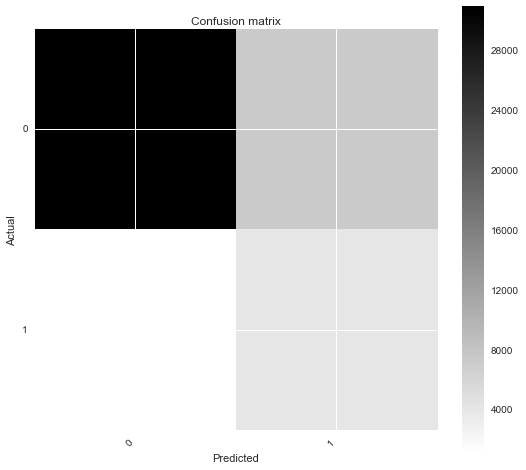

In [128]:
conf_mat_train.plot()
plt.show()

### 5.4.9 Creating the Logistic Regression model for test Data

In [126]:
#logit_test = sm.Logit(test['high_add'], test[train_cols_main])

# fit the model
#result_test = logit_test.fit()
#result_test.summary()

#result_test.conf_int()

#np.exp(result_test.params)

Predicting the Y high additive value using the Logistic model from training data.

In [129]:
# Predict Y using the logit function.
test['ypred'] = result_train8.predict(test[train_cols_main])

test['ypred_class'] = np.where(test['ypred']>0.12, '1', '0')
test['ypred_class'] = test['ypred_class'].astype(int)

/Users/vingadgil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/vingadgil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/vingadgil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [130]:
conf_mat_test = ConfusionMatrix(test['high_add'], test['ypred_class'])
#print("Confusion matrix:\n%s" % conf_mat_test)

conf_mat_test.print_stats()

Confusion Matrix:

Predicted      0     1  __all__
Actual                         
0          13167  3197    16364
1            486  1830     2316
__all__    13653  5027    18680


Overall Statistics:

Accuracy: 0.802837259101
95% CI: (0.79705814505631356, 0.80852195348596556)
No Information Rate: ToDo
P-Value [Acc > NIR]: 2.62955499275e-116
Kappa: 0.39588052831
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                        0          1
Population                                 18680      18680
P: Condition positive                      16364       2316
N: Condition negative                       2316      16364
Test outcome positive                      13653       5027
Test outcome negative                       5027      13653
TP: True Positive                          13167       1830
TN: True Negative                           1830      13167
FP: False Positive                           486       3197
FN: False Negative                          3

In [131]:
# Create ROC curve for Test model
false_positive_test, true_positive_test, thresholds = roc_curve(test['high_add'], test['ypred'])
roc_auc_test = auc(false_positive_test, true_positive_test)
roc_auc_test

0.87515608581371396

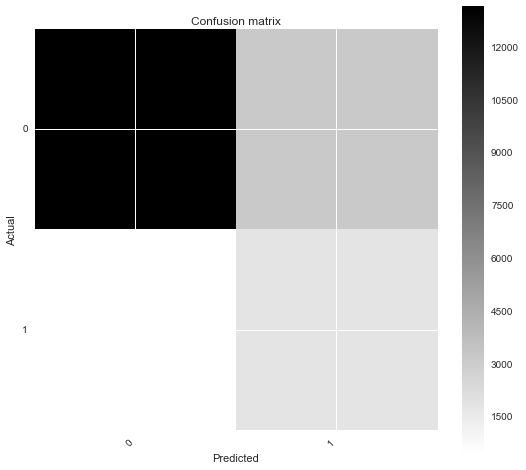

In [132]:
conf_mat_test.plot()
plt.show()

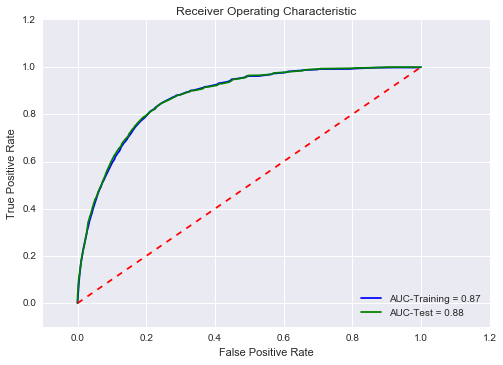

In [133]:
# Plot the actual ROC curve -
# Plot the curve
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_train, true_positive_train, 'b',
label='AUC-Training = %0.2f'% roc_auc_train)
plt.plot(false_positive_test, true_positive_test, 'g',
label='AUC-Test = %0.2f'% roc_auc_test)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Looking at the accuracy of the training model and test model (around 80%) we can conclude that model is good fit
and we can conclude certain ingredients / Categories or total number of ingredients do contribute for having high number of additives

Certain Observations from the Test Model -

1. Frozen Foods -'is_frozen' has 0.16 times less chances of having high additives .
2. Palm oil - Ingredients with Palm Oil has the maximum chances /probability - 2.20 times of having high additives
3. If the Food item is a Beverage ,we also have a huge chance of additive mainly if it is Carbonated. Similarly Sugary Snacks also has more chances of high additives.
4. Total number of ingredients also has an impact on the high additives in food. 
5. Plant based foods and Beverages has 0.32 times less chances of having high additives. So we can recommend eating more Plant based food as they are safe for consumption
6. Food with honey has least chances after frozen food i.e. 0.25 times less chances for additives.

Similair observations can be done for the remaining ingredients or Categories.